<a href="https://colab.research.google.com/github/tsubauaaa/AITrialTraining/blob/main/Training3/AITraining3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
 # Google Driveをマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# install MeCab
!apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab > /dev/null
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null 
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n > /dev/null 2>&1
!pip install mecab-python3 > /dev/null
# check path to "ipadic-neologd"
!echo `mecab-config --dicdir`"/mecab-ipadic-neologd"

!ln -s /etc/mecabrc /usr/local/etc/mecabrc

Cloning into 'mecab-ipadic-neologd'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 75 (delta 5), reused 54 (delta 0), pack-reused 0
Unpacking objects: 100% (75/75), done.
/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd


In [4]:
import json
import gensim
import MeCab
import pandas as pd
import re
import torch
import torch.nn as nn

In [5]:
decoder = json.JSONDecoder()
all_datasets_list = []
with open('/content/drive/My Drive/Colab Notebooks/AITraining/dataset_ja_dev.json') as f:
    line = f.readline()
    while line:
        all_datasets_list.append(decoder.raw_decode(line)[0])
        line = f.readline()

In [6]:
all_datasets_list[1]

{'language': 'ja',
 'product_category': 'wireless',
 'product_id': 'product_ja_0821731',
 'review_body': 'ホームボタン周りの気泡が全く抜けません。 返金をお願いしましたが、断られた。',
 'review_id': 'ja_0944897',
 'review_title': '欠陥品',
 'reviewer_id': 'reviewer_ja_0192786',
 'stars': '1'}

In [7]:
datasets_list = []
for data in all_datasets_list:
    review_body = data['review_body']
    stars = data['stars']
    datasets_list.append([review_body, stars])
datasets = pd.DataFrame(datasets_list, columns = ['review_body' , 'stars'])
datasets

,review_body,stars
0,味自体及び吸い心地は良いのだが、不良品が多過ぎる。私の場合５本のうち２本が蒸気も出ず、吸い込...,1
1,ホームボタン周りの気泡が全く抜けません。 返金をお願いしましたが、断られた。,1
2,新旧含めて4つのカーテンレールがあるのですが、使用出来るカーテンレールはありませんでした。 ...,1
3,予約注文でしたが、どこから特典であるpdfダウンロードすればよいのでしょうか…,1
4,前のレビューにもありましたが、片方が全く動きません。 返品しようにも、なんだかめんどくさいし...,1
...,...,...
4995,ミニオンが好きで、息子に買いました。 親子で楽しく遊んでます。,5
4996,まずレーザーの光が強いw 昔 ゲーセンで取ったヤツの3倍くらい 暗闇でレーザーの光が当たった...,5
4997,"色もち、発色もよく、ティントによくある""激しい唇の荒れ""が少ないのでとても使いやすいなと思い...",5
4998,1年前に別メーカーのバッテリーを交換して、使えましたが、スマホ確認のところで認識さらませんで...,5


In [8]:
tagger = MeCab.Tagger("-Owakati")
# param: dataset_list[]['review_body']
# return: 分かちした単語のリスト
def make_wakati(sentence):
    # MeCabで分かち書き
    sentence = tagger.parse(sentence)
    # 半角全角英数字除去
    sentence = re.sub(r'[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+', " ", sentence)
    # 記号もろもろ除去
    sentence = re.sub(r'[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—●★☆〇◎◆▼◇△□(：〜～＋=)／*&^%$#@!~`){}［］…\[\]\"\'\”\’:;<>?＜＞〔〕〈〉？、。・,\./『』【】「」→←○《》≪≫\n\u3000]+', "", sentence)
    # スペースで区切って形態素の配列へ
    wakati = sentence.split(" ")
    # 空の要素は削除
    wakati = list(filter(("").__ne__, wakati))
    return wakati

In [9]:
# w2vする
w2v_model = gensim.models.Word2Vec.load('/content/drive/My Drive/Colab Notebooks/AITraining/w2v/w2v.model')
word2vec = {}
no_words = []
for dataset in datasets_list:
    wakati = make_wakati(dataset[0])
    for word in wakati:
        if word in word2vec:
            continue
        if word not in list(w2v_model.wv.vocab):
            no_words.append(word)
            continue
        word2vec[word] = w2v_model.wv[word]
print(len(word2vec))
print(len(no_words))

12739
711


In [10]:
# 単語をベクトルデータに変換
# PyTorchのLSTMのインプットになるデータなので、もちろんtensor型で
def sentence2vec(sentence):
    wakati = make_wakati(sentence)
    return torch.tensor([word2vec[w] for w in wakati])

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# nn.Moduleを継承して新しいクラスを作る。決まり文句
class LSTMRegressor(nn.Module):
    # モデルで使う各ネットワークをコンストラクタで定義
    def __init__(self, embedding_dim, hidden_dim):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMRegressor, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。
        self.hidden_dim = hidden_dim
        # LSTMの隠れ層。これ１つでOK。超便利。
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        self.out = nn.Linear(hidden_dim, 1)

    # 順伝播処理はforward関数に記載
    def forward(self, sentence):
        # 2次元テンソルをLSTMに食わせられる様にviewで３次元テンソルにした上でLSTMへ流す。
        # 上記で説明した様にmany to oneのタスクを解きたいので、第二戻り値だけ使う。
        _, lstm_out = self.lstm(sentence)
        # lstm_out[0]は３次元テンソルになってしまっているので2次元に調整して全結合。
        output = self.out(lstm_out[0].view(-1, self.hidden_dim))
        return output

In [12]:
EMBEDDING_DIM = 200
HIDDEN_DIM = 128
lstm = LSTMRegressor(EMBEDDING_DIM, HIDDEN_DIM)
s1 = datasets_list[0][0]
s2 = datasets_list[0][1]
print(s1)
# 味自体及び吸い心地は良いのだが、不良品が多過ぎる。私の場合５本のうち２本が蒸気も出ず、吸い込み も出来なかった。腹が立ってごみ箱行きでした。こんなものは２度と購入する気はない。 返品するのも交渉するのも、金額も金額だからと面倒くさがってしない方が多いのではないか？ 最初から不良品多しとでも表記しておいたら如何？
print(make_wakati(s1))
# ['味', '自体', '及び', '吸い', '心地', 'は', '良い', 'の', 'だ', 'が', '不', '良品', 'が', '多', '過ぎる', '私', 'の', '場合', '本', 'の', 'うち', '本', 'が', '蒸気', 'も', '出', 'ず', '吸い込み', 'も', '出来', 'なかっ', 'た', '腹', 'が', '立っ', 'て', 'ごみ箱', '行き', 'でし', 'た', 'こんな', 'もの', 'は', '度', 'と', '購入', 'する', '気', 'は', 'ない', '返品', 'する', 'の', 'も', '交渉', 'する', 'の', 'も', '金額', 'も', '金額', 'だ', 'から', 'と', '面倒く', 'さ', 'がっ', 'て', 'し', 'ない', '方', 'が', '多い', 'の', 'で', 'は', 'ない', 'か', '最初', 'から', '不', '良品', '多し', 'と', 'でも', '表記', 'し', 'て', 'おい', 'たら', '如何']

inputs1 = sentence2vec(s1)
print(inputs1)
out = lstm(inputs1.view(len(inputs1), 1, -1))
print(out)
print(s2)

味自体及び吸い心地は良いのだが、不良品が多過ぎる。私の場合５本のうち２本が蒸気も出ず、吸い込み も出来なかった。腹が立ってごみ箱行きでした。こんなものは２度と購入する気はない。 返品するのも交渉するのも、金額も金額だからと面倒くさがってしない方が多いのではないか？ 最初から不良品多しとでも表記しておいたら如何？
['味', '自体', '及び', '吸い', '心地', 'は', '良い', 'の', 'だ', 'が', '不', '良品', 'が', '多', '過ぎる', '私', 'の', '場合', '本', 'の', 'うち', '本', 'が', '蒸気', 'も', '出', 'ず', '吸い込み', 'も', '出来', 'なかっ', 'た', '腹', 'が', '立っ', 'て', 'ごみ箱', '行き', 'でし', 'た', 'こんな', 'もの', 'は', '度', 'と', '購入', 'する', '気', 'は', 'ない', '返品', 'する', 'の', 'も', '交渉', 'する', 'の', 'も', '金額', 'も', '金額', 'だ', 'から', 'と', '面倒く', 'さ', 'がっ', 'て', 'し', 'ない', '方', 'が', '多い', 'の', 'で', 'は', 'ない', 'か', '最初', 'から', '不', '良品', '多し', 'と', 'でも', '表記', 'し', 'て', 'おい', 'たら', '如何']
tensor([[-0.4999, -0.6908, -2.5520,  ...,  1.2527, -0.7275,  0.6183],
        [ 0.3367,  0.8707, -0.7007,  ...,  0.4871,  0.3114, -0.0030],
        [ 1.1938, -0.3116,  0.3566,  ...,  2.1716,  1.3614, -1.0291],
        ...,
        [-0.6864, -1.0068,  1.2038,  ..., -1.4014, -1.4441,  1.2285],
        [-0.6333, -2.3974, -0.3745,  ..., -1

In [13]:
len_datasets = len(datasets_list)
# starsをtensorにする
category2index = {}
for i in range(len_datasets):
    star = datasets_list[i][1]
    if star in category2index: continue
    category2index[star] = len(category2index)
print(category2index)

def category2tensor(star):
    return torch.tensor([category2index[star]], dtype=torch.float)

print(category2tensor("2"))

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4}
tensor([1.])


In [14]:
from sklearn.model_selection import train_test_split
import torch.optim as optim
# 元データを7:3に分ける（7->学習、3->テスト）
traindata, testdata = train_test_split(datasets, train_size=0.7, shuffle=True)
# 単語のベクトル次元数
EMBEDDING_DIM = 200
# 隠れ層の次元数
HIDDEN_DIM = 128
# モデル宣言
model = LSTMRegressor(EMBEDDING_DIM, HIDDEN_DIM).to(device)
# 損失関数はNLLLoss()を使う。LogSoftmaxを使う時はこれを使うらしい。
loss_function = nn.MSELoss()
# 最適化の手法はSGDで。lossの減りに時間かかるけど、一旦はこれを使う。
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 各エポックの合計loss値を格納する
losses = []
for epoch in range(100):
    all_loss = 0
    for review, star in zip(traindata["review_body"], traindata["stars"]):
        # モデルが持ってる勾配の情報をリセット
        model.zero_grad()
        # 文章を単語IDの系列に変換（modelに食わせられる形に変換）
        try:
            inputs = sentence2vec(review).to(device)
        except KeyError:
            continue
        # 順伝播の結果を受け取る
        out = model(inputs.view(len(inputs), 1, -1))
        # 正解カテゴリをテンソル化
        answer = category2tensor(star).to(device)
        # 正解とのlossを計算
        loss = loss_function(out, answer)
        # 勾配をセット
        loss.backward()
        # 逆伝播でパラメータ更新
        optimizer.step()
        # lossを集計
        all_loss += loss.item()
    losses.append(all_loss)
    print("epoch", epoch, "\t" , "loss", all_loss)
print("done.")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0 	 loss 5317.967649936757
epoch 1 	 loss 4033.187906642862
epoch 2 	 loss 3483.67838528345
epoch 3 	 loss 2926.4702326237552
epoch 4 	 loss 2542.100880317967
epoch 5 	 loss 2105.488288227733
epoch 6 	 loss 1737.4972628120784
epoch 7 	 loss 1526.4240797292018
epoch 8 	 loss 1294.956155272608
epoch 9 	 loss 1033.9920587343122
epoch 10 	 loss 885.817691732648
epoch 11 	 loss 704.7961371352092
epoch 12 	 loss 568.0442358971792
epoch 13 	 loss 482.22400516949045
epoch 14 	 loss 420.17195611822314
epoch 15 	 loss 356.3754131910427
epoch 16 	 loss 305.2684133986606
epoch 17 	 loss 258.6660055110502
epoch 18 	 loss 223.57395159684
epoch 19 	 loss 203.39346838373945
epoch 20 	 loss 176.56467351534553
epoch 21 	 loss 152.5184159921095
epoch 22 	 loss 125.98299751213143
epoch 23 	 loss 107.58991707471597
epoch 24 	 loss 92.54088241339088
epoch 25 	 loss 80.26104997906734
epoch 26 	 loss 71.87922615033379
epoch 27 	 loss 66.84867324163491
epoch 28 	 loss 62.32904485324491
epoch 29 	 loss 59

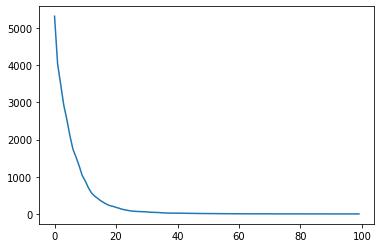

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)

In [21]:
from sklearn.metrics import mean_absolute_error

# テストデータの母数計算(1500)
test_num = len(testdata)
skip_num = 0
# 正解の件数
match = 0
# 絶対誤差用
y_preds = []
y_true = []
# 勾配自動計算OFF
with torch.no_grad():
    for review, star in zip(testdata["review_body"], testdata["stars"]):
        # テストデータの予測
        try:
            inputs = sentence2vec(review).to(device)
        except KeyError:
            skip_num += 1
            continue
        out = model(inputs.view(len(inputs), 1, -1))
        y_preds.append(out.item())
        y_true.append(int(star))

        # outを四捨五入して一致数を数える
        predict = torch.round(out).to(device)
        if predict < 0:
            predict = torch.tensor(0).to(device)
        elif predict > 4:
            predict = torch.tensor(4).to(device)

        answer = category2tensor(star).to(device)
        if predict == answer:
            match += 1
tested_num = test_num - skip_num
mae = mean_absolute_error(y_true, y_preds)
print(f"Correct answer rate: {match / tested_num}, match: {match}, tested_num: {tested_num}")
print(f"Mean Absolute Error: {mae}")

Correct answer rate: 0.3368660105980318, match: 445, tested_num: 1321
Mean Absolute Error: 1.2965448602503848
